In [14]:
! nvidia-smi

Fri Dec 17 01:22:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
# recomended to run this repo from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading and Pre-Processing

We have adapted the pre-processing part from the following tutorial : [link](https://nathancooper.io/i-am-a-nerd/code/summarization/deep-learning/seq2seq/2020/12/26/Improved_Code_Commenter.html).

In [16]:
# collapse
# Download and install the necessary dependencies
! pip install -q torch==1.4.0 -f https://download.pytorch.org/whl/cu101/torch_stable.html
! pip install -q transformers==3.5.0 

In [ ]:
# collapse
%cd /content/
!pip install tree-sitter==0.19.0
!pip install -U tree-hugger PyYAML
!create_libs -c python

In [ ]:
# run once to clone repo
! git clone -q https://github.com/mushus96/CodeToCommentGenerator

In [ ]:
# cd to root dir of repo
%cd /content/drive/MyDrive/CodeToCommentGenerator

In [ ]:
# run once to download the CodeSearchNet Challenge dataset for the Python programming language (replace python with desired language)
! wget -q https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/python.zip
! unzip -qq python.zip

In [ ]:
curr_lang = 'python'

We will select a subset of the data based on the sample size.

In [ ]:
# collapse
import pandas as pd

from pathlib import Path
from typing import List, Optional

# Code from CodeSearchNetChallenge: https://github.com/github/CodeSearchNet/blob/master/notebooks/ExploreData.ipynb
def jsonl_list_to_dataframe(file_list, columns=['code', 'docstring']):
    """Load a list of jsonl.gz files into a pandas DataFrame."""
    return pd.concat([pd.read_json(f,
                                   orient='records', 
                                   compression='gzip',
                                   lines=True)[columns] 
                      for f in file_list], sort=False)

def get_dfs(path: Path) -> List[pd.DataFrame]:
    """Grabs the different data splits and converts them into dataframes"""
    dfs = []
    for split in ["train", "valid", "test"]:
        files = sorted((path/split).glob("**/*.gz"))
        df = jsonl_list_to_dataframe(files).rename(columns = {'code': 'mthd', 'docstring': 'cmt'})
        dfs.append(df)
        
    return dfs

path = Path('.')
lang_path = curr_lang + "/final/jsonl"
df_trn, df_val, df_tst = get_dfs(path/lang_path)
sample = 0.1
df_trn = df_trn.sample(frac = sample)
df_val = df_val.sample(frac = sample)
df_tst = df_tst.sample(frac = sample)

len(df_trn), len(df_val), len(df_tst)

(41218, 2311, 2218)

In [17]:
df_trn.head()

,mthd,cmt
11857,"def _PrintSessionsOverview(self, storage_reade...",Prints a sessions overview.\n\n Args:\n ...
21602,"def ncores_allocated(self):\n """"""\n ...",Returns the number of CPUs allocated in this m...
2984,"def cli(env, storage_type, size, iops, tier,\n...",Order a file storage volume.\n\n Valid size...
15268,"def from_result(cls, container, result):\n ...",Create from ambiguous result.
2433,"def union(self, query, all=False):\n """"...",Add a union statement to the query\n\n ...


Removing any non-ascii characters to simplify the problem so that the model only has to think about generating English comments.

In [18]:

def is_ascii(s):
    '''
    Determines if the given string contains only ascii characters

    :param s: the string to check
    :returns: whether or not the given string contains only ascii characters
    '''
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

df_trn = df_trn[df_trn['mthd'].apply(lambda x: is_ascii(x))]
df_val = df_val[df_val['mthd'].apply(lambda x: is_ascii(x))]
df_tst = df_tst[df_tst['mthd'].apply(lambda x: is_ascii(x))]

df_trn = df_trn[df_trn['cmt'].apply(lambda x: is_ascii(x))]
df_val = df_val[df_val['cmt'].apply(lambda x: is_ascii(x))]
df_tst = df_tst[df_tst['cmt'].apply(lambda x: is_ascii(x))]

len(df_trn), len(df_val), len(df_tst)

(40564, 2266, 2204)

Removing  all  the  comments  from  the code to avoid the model from cheating as itcan simply remember the comment from themethod itself.

In [19]:
from tqdm.auto import tqdm
import re
def remove_comments_from_method(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Remove python comments

    :param df: the pandas dataframe to remove the python comments from
    :returns: a new pandas dataframe with the python comments removed
    '''
    methods = []
    comments = []
    for i, row in tqdm(list(df.iterrows())):
        mthd = row["mthd"]
        mthd = re.sub('[\"\'][\s\S]+[\"\']', "", mthd)
        comments.append(row["cmt"])
        methods.append(mthd)
    new_df = pd.DataFrame(zip(methods, comments), columns = ["mthd", "cmt"])

    return new_df

df_trn = remove_comments_from_method(df_trn)
df_val = remove_comments_from_method(df_val)
df_tst = remove_comments_from_method(df_tst)



  0%|          | 0/40564 [00:00<?, ?it/s]

  0%|          | 0/2266 [00:00<?, ?it/s]

  0%|          | 0/2204 [00:00<?, ?it/s]

We remove  all  code-comment  pairs  where  the size of the code is smaller than the method because  the  comments  in  such  cases  may contain extra information related to how the method  is  being  used  by  other  parts  of  thecode.

In [20]:
# collapse
df_trn = df_trn[df_trn.apply(lambda row: len(row.mthd) > len(row.cmt), axis = 1)]
df_val = df_val[df_val.apply(lambda row: len(row.mthd) > len(row.cmt), axis = 1)]
df_tst = df_tst[df_tst.apply(lambda row: len(row.mthd) > len(row.cmt), axis = 1)]

len(df_trn), len(df_val), len(df_tst)

(21675, 1166, 1238)

Removing all the code-comment pairs which  have  empty  comments  and  duplicate code-comment pairs

In [21]:
# collapse
df_trn = df_trn.applymap(lambda x: ' '.join(x.split()).lower())
df_val = df_val.applymap(lambda x: ' '.join(x.split()).lower())
df_tst = df_tst.applymap(lambda x: ' '.join(x.split()).lower())

df_trn = df_trn[~(df_trn['cmt'] == '')]
df_val = df_val[~(df_val['cmt'] == '')]
df_tst = df_tst[~(df_tst['cmt'] == '')]

df_trn = df_trn[~df_trn['cmt'].duplicated()]
df_val = df_val[~df_val['cmt'].duplicated()]
df_tst = df_tst[~df_tst['cmt'].duplicated()]

len(df_trn), len(df_val), len(df_tst)

(21153, 1159, 1233)

Removing all outliers from the data by filtering all the code-comment pairs where the  method  length  is  outside  the  95th  per-centile of the method lengths and converting everything to lowercase

In [22]:
# collapse
import numpy as np

from collections import Counter
from statistics import mean, median, stdev
from transformers import AutoTokenizer

def get_counter(df: pd.DataFrame, tokenizer: AutoTokenizer, col: str) -> Counter:
    '''
    Get the counts for each token in a given pandas dataframe column

    :param df: the pandas dataframe to get the counts of tokens from
    :param tokenizer: the tokenizer to use for tokenizing the rows in the pandas
    dataframe
    :param col: the column to grab rows from when tokenizing
    :returns: the counts of each token in the given pandas dataframe
    column
    '''
    toks = []
    for i, row in df.iterrows():
        toks.extend(tokenizer.tokenize(row[col]))
            
    cnt = Counter()
    for tok in toks:
        cnt[tok] += 1  
    return cnt

tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
mthd_cnt = get_counter(df_trn, tokenizer, 'mthd')
cmt_cnt = get_counter(df_trn, tokenizer, 'cmt')
mthd_lens = df_trn.mthd.apply(lambda x: len(tokenizer.tokenize(x))).values
cmt_lens = df_trn.cmt.apply(lambda x: len(tokenizer.tokenize(x))).values
max_mthd_len = int(np.quantile(mthd_lens, 0.95))
max_cmt_len = int(np.quantile(cmt_lens, 0.95))

Downloading:   0%|          | 0.00/498 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

In [23]:
# collapse
import matplotlib.pyplot as plt

def plot_counts(counts:Counter, top_k: Optional[int] = 30):
    '''
    Plot a bar chart of the most common tokens

    :param counts: the counts of each token
    :param top_k: the number of tokens to display in the plot
    '''
    labels, values = zip(*counts.most_common()[:top_k])

    indexes = np.arange(len(labels))
    width = 1
    plt.figure(num=None, figsize=(22, 4), dpi=60, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

Let's look at the most common tokens in our methods and comments.

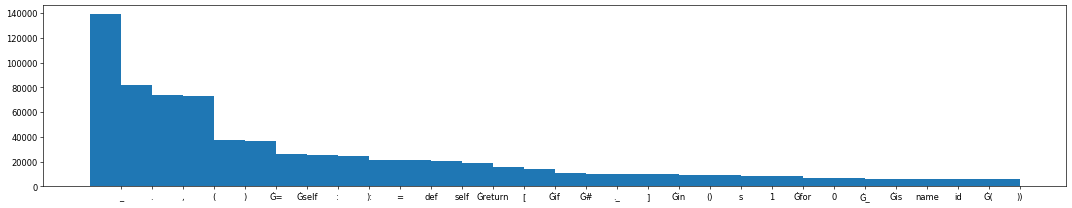

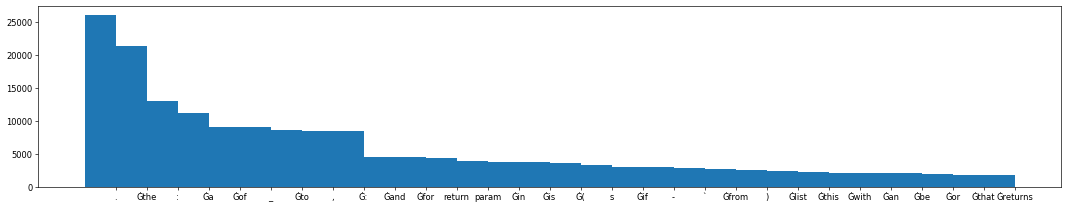

In [24]:
plot_counts(mthd_cnt, top_k = 30)
plot_counts(cmt_cnt, top_k = 30)

In [25]:
# collapse
def plot_hist(lens: List[int], n_bins: Optional[int] = 50):
    '''
    Plot a histogram of the given number of tokens in a column 

    :param lens: the number of tokens in a column
    :param n_bins: the number of bins to sort the number of tokens into
    '''
    n, bins, patches = plt.hist(lens, n_bins, facecolor='blue', alpha=0.9)
    plt.show()

Now, let's look at the distribution of method and comment lengths.

78 52 99.71960689854328


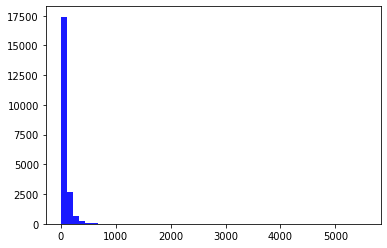

24 14 30.72458299147443


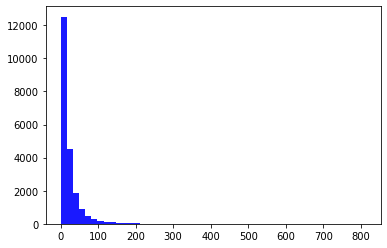

In [26]:
print(mean(mthd_lens), median(mthd_lens), stdev(mthd_lens))
plot_hist(mthd_lens)
print(mean(cmt_lens), median(cmt_lens), stdev(cmt_lens))
plot_hist(cmt_lens)

In [27]:
# collapse
def filter_len(
    row: pd.Series, tokenizer: AutoTokenizer, mthd_len: int, cmt_len: int
    ) -> bool:
    '''
    Determine if a given panda dataframe row has a method or comment that has
    more tokens than max length

    :param row: the row to check if it has a method or comment that is too long
    :param tokenizer: the tokenizer to tokenize a method or comment
    :param mthd_len: the max number of tokens a method can have
    :param cmt_len: the max number of tokens a comment can have
    :returns: whether or not the given row have a method or comment that have
    more tokens than a max length
    '''
    return len(tokenizer.tokenize(row.mthd)) < mthd_len and len(tokenizer.tokenize(row.cmt)) < cmt_len

df_trn = df_trn[df_trn.apply(
    lambda row: filter_len(
        row, tokenizer, max_mthd_len,
        max_cmt_len
    ), axis = 1
)]
df_val = df_val[df_val.apply(
    lambda row: filter_len(
        row, tokenizer, max_mthd_len,
        max_cmt_len
    ), axis = 1
)]
df_tst = df_tst[df_tst.apply(
    lambda row: filter_len(
        row, tokenizer, max_mthd_len,
        max_cmt_len
    ), axis = 1
)]

len(df_trn), len(df_val), len(df_tst)

(19444, 1045, 1110)

# CodeBERT Model Training


In [ ]:
## cd to code directory of repo
%cd /content/drive/My Drive/CodeToCommentGenerator/code

Converting pandas data-frames to 
'jsonl' files to be used by the model

In [30]:
# collapse
import json

df_trn['code_tokens'] = df_trn.mthd.apply(lambda x: x.split())
df_trn['docstring_tokens'] = df_trn.cmt.apply(lambda x: x.split())
with open(curr_lang+'/train.jsonl','w') as f:
    for _, row in df_trn.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

df_val['code_tokens'] = df_val.mthd.apply(lambda x: x.split())
df_val['docstring_tokens'] = df_val.cmt.apply(lambda x: x.split())
with open(curr_lang+'/valid.jsonl','w') as f:
    for _, row in df_val.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

df_tst['code_tokens'] = df_tst.mthd.apply(lambda x: x.split())
df_tst['docstring_tokens'] = df_tst.cmt.apply(lambda x: x.split())
with open(curr_lang+'/test.jsonl','w') as f:
    for _, row in df_tst.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

In [ ]:
lang = curr_lang 
model_lang='python'
lr = 5e-5
batch_size = 16 # change depending on the GPU Colab gives you
beam_size = 10
source_length = 256
target_length = max_cmt_len
data_dir = '.'
output_dir = f'model/{lang}'
train_file = f'{data_dir}/{lang}/train.jsonl'
dev_file = f'{data_dir}/{lang}/valid.jsonl'
epochs = 5 
pretrained_model = 'microsoft/codebert-base'
load_model_path = f'model/{lang}/checkpoint-best-bleu/pytorch_model.bin'

! python run.py \
    --do_train \
    --do_eval \
    --do_lower_case \
    --model_type roberta \
    --model_name_or_path {pretrained_model} \
    --train_filename {train_file} \
    --dev_filename {dev_file} \
    --output_dir {output_dir} \
    --max_source_length {source_length} \
    --max_target_length {target_length} \
    --beam_size {beam_size} \
    --train_batch_size {batch_size} \
    --eval_batch_size {batch_size} \
    --learning_rate {lr} \
    --num_train_epochs {epochs} \
    --load_model_path {load_model_path}

12/15/2021 03:48:53 - INFO - __main__ -   Namespace(adam_epsilon=1e-08, beam_size=10, config_name='', dev_filename='./python/valid.jsonl', do_eval=True, do_lower_case=True, do_test=False, do_train=True, eval_batch_size=16, eval_steps=-1, gradient_accumulation_steps=1, learning_rate=5e-05, load_model_path='model/python/checkpoint-best-bleu/pytorch_model.bin', local_rank=-1, max_grad_norm=1.0, max_source_length=256, max_steps=-1, max_target_length=70, model_name_or_path='microsoft/codebert-base', model_type='roberta', no_cuda=False, num_train_epochs=5, output_dir='model/python', seed=42, test_filename=None, tokenizer_name='', train_batch_size=16, train_filename='./python/train.jsonl', train_steps=-1, warmup_steps=0, weight_decay=0.0)
12/15/2021 03:48:53 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False
Downloading: 100% 499M/499M [00:08<00:00, 59.4MB/s]
12/15/2021 03:49:07 - INFO - __main__ -   reload model from model/python/checkpoint-best-bl

# CodeBERT Model Testing

In [ ]:
batch_size=64
lang = curr_lang 
model_lang='python'
data_dir = '.'
beam_size = 10
source_length = 256
target_length = max_cmt_len
output_dir = f'model/{model_lang}'#f'model/{lang}'
dev_file=f"{data_dir}/{lang}/valid.jsonl"
test_file=f"{data_dir}/{lang}/test.jsonl"
test_model=f"{output_dir}/checkpoint-best-bleu/pytorch_model.bin" #checkpoint for test

! python run.py \
    --do_test \
    --model_type roberta \
    --model_name_or_path microsoft/codebert-base \
    --load_model_path {test_model} \
    --dev_filename {dev_file} \
    --test_filename {test_file} \
    --output_dir {output_dir} \
    --max_source_length {source_length} \
    --max_target_length {target_length} \
    --beam_size {beam_size} \
    --eval_batch_size {batch_size}

12/15/2021 14:35:27 - INFO - __main__ -   Namespace(adam_epsilon=1e-08, beam_size=10, config_name='', dev_filename='./ruby/valid.jsonl', do_eval=False, do_lower_case=False, do_test=True, do_train=False, eval_batch_size=64, eval_steps=-1, gradient_accumulation_steps=1, learning_rate=5e-05, load_model_path='model/python/checkpoint-best-bleu/pytorch_model.bin', local_rank=-1, max_grad_norm=1.0, max_source_length=256, max_steps=-1, max_target_length=57, model_name_or_path='microsoft/codebert-base', model_type='roberta', no_cuda=False, num_train_epochs=3, output_dir='model/python', seed=42, test_filename='./ruby/test.jsonl', tokenizer_name='', train_batch_size=8, train_filename=None, train_steps=-1, warmup_steps=0, weight_decay=0.0)
12/15/2021 14:35:27 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False
12/15/2021 14:35:30 - INFO - __main__ -   reload model from model/python/checkpoint-best-bleu/pytorch_model.bin
12/15/2021 14:35:34 - INFO - __main

In [ ]:
pretrained_model = 'microsoft/codebert-base'

In [ ]:
# collapse
import torch

import torch.nn as nn

from model import Seq2Seq
from transformers import RobertaConfig, RobertaModel

config = RobertaConfig.from_pretrained(pretrained_model)
encoder = RobertaModel.from_pretrained(pretrained_model, config = config)    
decoder_layer = nn.TransformerDecoderLayer(d_model=config.hidden_size, nhead=config.num_attention_heads)
# decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=8)
model = Seq2Seq(encoder = encoder,decoder = decoder,config=config,
                beam_size=beam_size,max_length=target_length,
                sos_id=tokenizer.cls_token_id,eos_id=tokenizer.sep_token_id)
model.load_state_dict(torch.load(Path(output_dir)/"checkpoint-last/pytorch_model.bin"))
model.to('cuda')

Seq2Seq(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [ ]:
idx = 0
TEXT_TO_SUMMARIZE = df_val.mthd.values[idx]
print('Code:', TEXT_TO_SUMMARIZE)
print('Original Comment:', df_val.cmt.values[idx])

Code: def version(self): ], } ver.save() return ver
Original Comment: create a new version under this service.


In [ ]:
# collapse
from run import convert_examples_to_features, Example

class Args:
    max_source_length = source_length
    max_target_length = target_length

args = Args()

def get_preds(df: pd.DataFrame):
    ps = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        examples = [
            Example(idx, source = row.mthd, target = row.cmt)
        ]
        eval_features = convert_examples_to_features(
            examples, tokenizer, args, stage='test'
        )
        source_ids = torch.tensor(eval_features[0].source_ids, dtype = torch.long).unsqueeze(0).to('cuda')
        source_mask = torch.tensor(eval_features[0].source_mask, dtype = torch.long).unsqueeze(0).to('cuda')

        with torch.no_grad():
            preds = model(source_ids = source_ids, source_mask = source_mask)  
            for pred in preds:
                t = pred[0].cpu().numpy()
                t = list(t)
                if 0 in t:
                    t = t[:t.index(0)]
                text = tokenizer.decode(t,clean_up_tokenization_spaces=False)
                ps.append(text)
    
    return ps

In [ ]:
df_val = df_val.reset_index()
preds = get_preds(df_val.head(10))
for idx, row in df_val.head(10).iterrows():
    print('Code:', row.mthd)
    print('Original Comment:', row.cmt)
    print('Generated Comment:', preds[idx])
    print('='*40)

  0%|          | 0/10 [00:00<?, ?it/s]

Code: def version(self): ], } ver.save() return ver
Original Comment: create a new version under this service.
Generated Comment: return a version of a version.
Code: def peers(symbol, token=, token, version)
Original Comment: peers of ticker https://iexcloud.io/docs/api/#peers 8am utc daily args: symbol (string); ticker to request token (string); access token version (string); api version returns: dict: result
Generated Comment: returns the node.
Code: def writelist(self, register, data): , register, data)
Original Comment: write bytes to the specified register.
Generated Comment: create a record to register
Code: def configure(self, reboot=1): ) r.sudo(r.env.set_hostname_command) if r.env.auto_reboot and int(reboot): r.reboot()
Original Comment: assigns a name to the server accessible from user space. note, we add the name to /etc/hosts since not all programs use /etc/hostname to reliably identify the server hostname.
Generated Comment: run command.
Code: def _init(self): % self.prov

In [ ]:
def get_preds_losses(df: pd.DataFrame):
    ps = []
    losses = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        examples = [
            Example(idx, source = row.mthd, target = row.cmt)
        ]
        eval_features = convert_examples_to_features(
            examples, tokenizer, args, stage='test'
        )
        source_ids = torch.tensor([f.source_ids for f in eval_features], dtype = torch.long).to('cuda')
        source_mask = torch.tensor([f.source_mask for f in eval_features], dtype = torch.long).to('cuda')
        target_ids = torch.tensor([f.target_ids for f in eval_features], dtype = torch.long).to('cuda')
        target_mask = torch.tensor([f.target_mask for f in eval_features], dtype = torch.long).to('cuda')

        with torch.no_grad():
            _, loss, _ = model(
                source_ids = source_ids, source_mask = source_mask,
                target_ids = target_ids, target_mask = target_mask
            )
            preds = model(source_ids = source_ids, source_mask = source_mask)  
            for pred in preds:
                t = pred[0].cpu().numpy()
                t = list(t)
                if 0 in t:
                    t = t[:t.index(0)]
                text = tokenizer.decode(t,clean_up_tokenization_spaces=False)
                ps.append(text)
                losses.append(loss.item())
    
    return ps, losses

In [ ]:
df_head = df_val.copy()
ps, losses = get_preds_losses(df_head)
df_head['pred'] = ps
df_head['loss'] = losses
df_sorted_losses = df_head.sort_values('loss', ascending = False)

for _, row in df_sorted_losses.head(10).iterrows():
    print('Code:', row.mthd)
    print('Original Comment:', row.cmt)
    print('Generated Comment:', row.pred)
    print(row.loss)
    print('='*40)

  0%|          | 0/175 [00:00<?, ?it/s]

Code: def authenticate(self, request): % user.username raise exceptions.authenticationfailed(msg) return (token.user, token)
Original Comment: returns two-tuple of (user, token) if authentication succeeds, or none otherwise.
Generated Comment: auth authentication.
25.256330490112305
Code: def _save_private_file(filename, json_contents): )) shutil.move(temp_filename, filename)
Original Comment: saves a file with read-write permissions on for the owner. args: filename: string. absolute path to file. json_contents: json serializable object to be saved.
Generated Comment: save a json file.
24.393798828125
Code: def list_characteristics(self): ) return map(bluezgattcharacteristic, get_provider()._get_objects_by_path(paths))
Original Comment: return list of gatt characteristics that have been discovered for this service.
Generated Comment: generate the list of the given service.
24.34803009033203
Code: def uptime(): : _uptime_windows}.get(sys.platform, _uptime_bsd)() or \ _uptime_bsd() or _u

### Graph-Code BERT Model Training and Evaluation

In [ ]:
lang = 'python' # programming language
lr = 5e-5
batch_size = 16 # change depending on the GPU Colab gives you
beam_size = 10
source_length = 256
target_length = max_cmt_len
data_dir = '.'
output_dir = f'model/{lang}'
train_file = f'{data_dir}/{lang}/train.jsonl'
dev_file = f'{data_dir}/{lang}/valid.jsonl'
epochs = 5 
pretrained_model = 'microsoft/graphcodebert-base'
load_model_path = f'model/{lang}/checkpoint-best-bleu/pytorch_model.bin'

! python run.py \
    --do_train \
    --do_eval \
    --do_lower_case \
    --model_type roberta \
    --model_name_or_path {pretrained_model} \
    --train_filename {train_file} \
    --dev_filename {dev_file} \
    --output_dir {output_dir} \
    --max_source_length {source_length} \
    --max_target_length {target_length} \
    --beam_size {beam_size} \
    --train_batch_size {batch_size} \
    --eval_batch_size {batch_size} \
    --learning_rate {lr} \
    --num_train_epochs {epochs} \
    --load_model_path {load_model_path}

In [ ]:
batch_size=64
lang = curr_lang 
model_lang='python'
data_dir = '.'
beam_size = 10
source_length = 256
target_length = max_cmt_len
output_dir = f'model/{model_lang}' #f'model/{lang}_new' 
dev_file=f"{data_dir}/{lang}/valid.jsonl"
test_file=f"{data_dir}/{lang}/test.jsonl"
test_model=f"{output_dir}/checkpoint-best-bleu/pytorch_model.bin" #f"{output_dir}/checkpoint-best-bleu/pytorch_model.bin" #checkpoint for test

! python run.py \
    --do_test \
    --model_type roberta \
    --model_name_or_path microsoft/graphcodebert-base \
    --load_model_path {test_model} \
    --dev_filename {dev_file} \
    --test_filename {test_file} \
    --output_dir {output_dir} \
    --max_source_length {source_length} \
    --max_target_length {target_length} \
    --beam_size {beam_size} \
    --eval_batch_size {batch_size} 

In [ ]:
# collapse
import torch

import torch.nn as nn

from model import Seq2Seq
from transformers import RobertaConfig, RobertaModel
pretrained_model = 'microsoft/graphcodebert-base'
config = RobertaConfig.from_pretrained(pretrained_model)
encoder = RobertaModel.from_pretrained(pretrained_model, config = config)    
decoder_layer = nn.TransformerDecoderLayer(d_model=config.hidden_size, nhead=config.num_attention_heads)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
# decoder = nn.TransformerDecoder(decoder_layer, num_layers=8)
model = Seq2Seq(encoder = encoder,decoder = decoder,config=config,
                beam_size=beam_size,max_length=target_length,
                sos_id=tokenizer.cls_token_id,eos_id=tokenizer.sep_token_id)
model.load_state_dict(torch.load(Path(output_dir)/"checkpoint-last/pytorch_model.bin"))
model.to('cuda')

In [ ]:
# collapse
from run import convert_examples_to_features, Example, get_attn_mask

class Args:
    max_source_length = source_length
    max_target_length = target_length

args = Args()

def get_preds(df: pd.DataFrame):
    ps = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        examples = [
            Example(idx, source = row.mthd, target = row.cmt)
        ]
        eval_features = convert_examples_to_features(
            examples, tokenizer, args, stage='test'
        )
        source_ids = torch.tensor(eval_features[0].source_ids, dtype = torch.long).unsqueeze(0).to('cuda')
        source_mask = torch.tensor(eval_features[0].source_mask, dtype = torch.long).unsqueeze(0).to('cuda')
        att_mask = torch.tensor(get_attn_mask(eval_features[0], args), dtype = torch.bool).unsqueeze(0).to('cuda') 
        position_idx = torch.tensor(eval_features[0].position_idx, dtype = torch.long).unsqueeze(0).to('cuda')

        with torch.no_grad():
            preds = model(source_ids = source_ids, source_mask = source_mask, position_idx=position_idx, attn_mask = att_mask)  
            for pred in preds:
                t = pred[0].cpu().numpy()
                t = list(t)
                if 0 in t:
                    t = t[:t.index(0)]
                text = tokenizer.decode(t,clean_up_tokenization_spaces=False)
                ps.append(text)
    
    return ps

In [ ]:
df_val = df_val.reset_index()
preds = get_preds(df_val.head(10))
for idx, row in df_val.head(10).iterrows():
    print('Code:', row.mthd)
    print('Original Comment:', row.cmt)
    print('Generated Comment:', preds[idx])
    print('='*40)

In [ ]:
def get_preds_losses(df: pd.DataFrame):
    ps = []
    losses = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        examples = [
            Example(idx, source = row.mthd, target = row.cmt)
        ]
        eval_features = convert_examples_to_features(
            examples, tokenizer, args, stage='test'
        )
        source_ids = torch.tensor([f.source_ids for f in eval_features], dtype = torch.long).to('cuda')
        source_mask = torch.tensor([f.source_mask for f in eval_features], dtype = torch.long).to('cuda')
        target_ids = torch.tensor([f.target_ids for f in eval_features], dtype = torch.long).to('cuda')
        target_mask = torch.tensor([f.target_mask for f in eval_features], dtype = torch.long).to('cuda')
        att_mask = torch.tensor(get_attn_mask(eval_features[0], args), dtype = torch.bool).unsqueeze(0).to('cuda') 
        position_idx = torch.tensor(eval_features[0].position_idx, dtype = torch.long).unsqueeze(0).to('cuda')

        with torch.no_grad():
            _, loss, _ = model(
                source_ids = source_ids, source_mask = source_mask,
                position_idx = position_idx, attn_mask = att_mask,
                target_ids = target_ids, target_mask = target_mask
            )
            preds = model(source_ids = source_ids, source_mask = source_mask,  position_idx = position_idx, attn_mask = att_mask)  
            for pred in preds:
                t = pred[0].cpu().numpy()
                t = list(t)
                if 0 in t:
                    t = t[:t.index(0)]
                text = tokenizer.decode(t,clean_up_tokenization_spaces=False)
                ps.append(text)
                losses.append(loss.item())
    
    return ps, losses

In [ ]:
df_head = df_val.copy()
ps, losses = get_preds_losses(df_head)
df_head['pred'] = ps
df_head['loss'] = losses
df_sorted_losses = df_head.sort_values('loss', ascending = True)

for _, row in df_sorted_losses.head(10).iterrows():
    print('Code:', row.mthd)
    print('Original Comment:', row.cmt)
    print('Generated Comment:', row.pred)
    print(row.loss)
    print('='*40)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# x_epochs  = range(1,11)
# y_bleu = np.array([3.98, 4.5, 4.8, 4.79, 4.92, 5.06, 4.98, 5.46, 5.57, 5.65])*1.5


y_bleu = np.array([10.16, 9.7, 10.34, 10.27, 10.5])
x_epochs  = range(1,y_bleu.shape[0]+1)


plt.scatter(x_epochs, y_bleu)
plt.plot(x_epochs, y_bleu)
plt.xlabel("epochs")
plt.ylabel("BLEU-4 score")
plt.show()